
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Simulate Astronomical Tide using U-tide library

inputs required: 
  * Astronomical Tide historical time series at the study site 
  
in this notebook: 
  * Tidal armonic analysis based on U-tide library

### Workflow:

<div>
<img src="resources/nb01_03.png" width="300px">
</div>


Tides are simulated by determining the leading constituents using the U_Tide package applied to observed water levels. Superimposing the predicted tides as an independent process still inherently accounts for the timing of events during the calendar year (i.e., king tides in January and February due to Earth’s orbital position are associated with realistic winter weather patterns produced by the emulator). 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op

# python libs
import numpy as np
import xarray as xr
from scipy.stats import linregress
from datetime import datetime, timedelta

import matplotlib

# custom libs
import utide # https://github.com/wesleybowman/UTide

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.plotting.tides import Plot_AstronomicalTide, Plot_ValidateTTIDE, Plot_Validate_scatter


C:\Users\lcag075\AppData\Local\Continuum\anaconda2\envs\teslakit\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO')


In [3]:
_, TIDE_astro = db.Load_TIDE_hist()  # astronomical tide historical data
TIDE_astro

<xarray.Dataset>
Dimensions:           (time: 226440)
Coordinates:
  * time              (time) datetime64[ns] 1993-05-01 ... 2019-02-28T23:00:00
Data variables:
    WaterLevel        (time) float64 ...
    WaterTemp         (time) float64 ...
    AirTemp           (time) float64 ...
    BPressure         (time) float64 ...
    Residuals         (time) float64 ...
    AdjResiduals      (time) float64 ...
    WindDirection     (time) float64 ...
    WindGust          (time) float64 ...
    WindSpeed         (time) float64 ...
    Marshall Islands  (time) float64 ...
    predicted         (time) float64 ...

In [5]:
TIDE = TIDE_astro.WaterLevel-TIDE_astro.Residuals
TIDE

<xarray.DataArray (time: 226440)>
array([  nan,   nan,   nan, ..., 1.044, 1.14 , 1.292])
Coordinates:
  * time     (time) datetime64[ns] 1993-05-01 ... 2019-02-28T23:00:00

In [6]:
# --------------------------------------
# Load astronomical tide historical and set simulation dates and remove residuals and slr (trend)

time = TIDE.time.values[:]
tide = TIDE.values[:] * 1000  # (m to mm)

lr_time = np.array(range(len(time)))  # for linregress
mask = ~np.isnan(lr_time) & ~np.isnan(tide)
slope, intercept, r_value, p_value, std_err = linregress(lr_time[mask], tide[mask])
slr = intercept + slope * lr_time

tide=tide-slr

In [8]:
#We add this new variable as the predicted in ROI
TIDE_astro['predicted']=('time',tide)
TIDE_astro.to_netcdf(os.path.join(r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA\sites\MAJURO\TIDE','tide_astro_hist2.nc'))

In [6]:
# TG latitude
lat0 = 7.11

# Simulation dates (years)
y1_sim = 2000
y2_sim = 3000



## Astronomical Tide

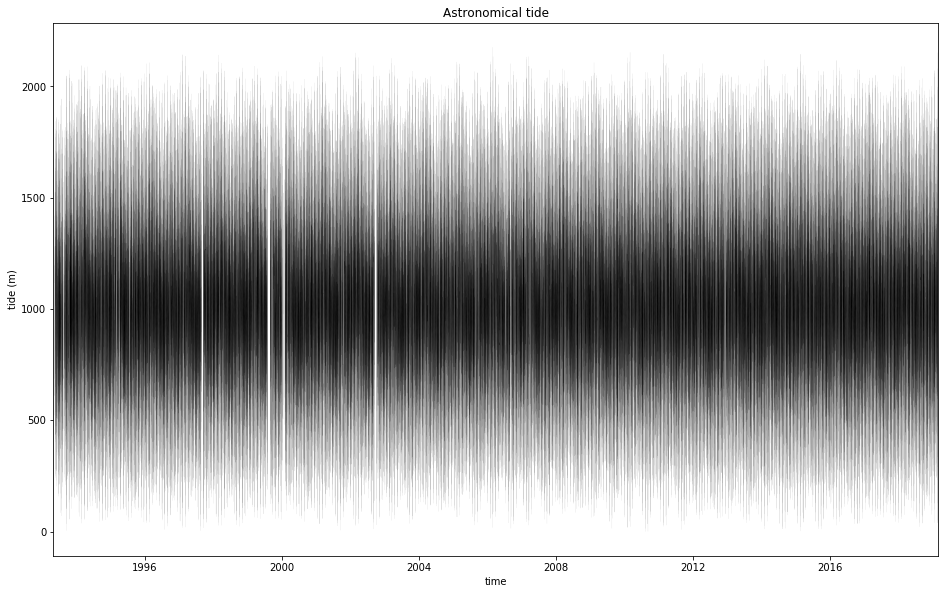

In [7]:
# --------------------------------------
# astronomical tide data

# remove tide nanmin
TIDE = TIDE - np.nanmin(TIDE)

# Plot astronomical tide

Plot_AstronomicalTide(time, tide-np.nanmin(tide));



## Astronomical Tide - Fitting

solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.


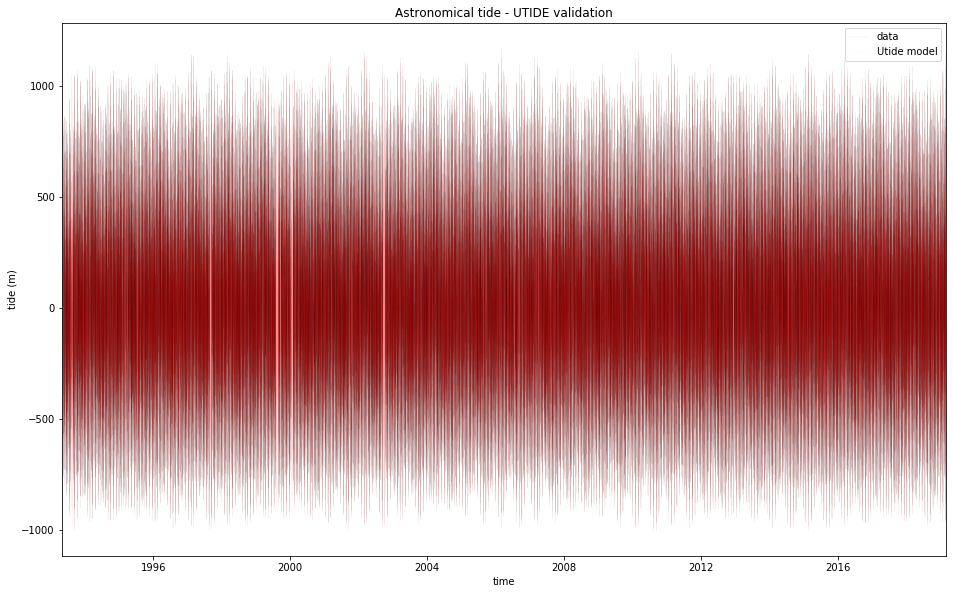

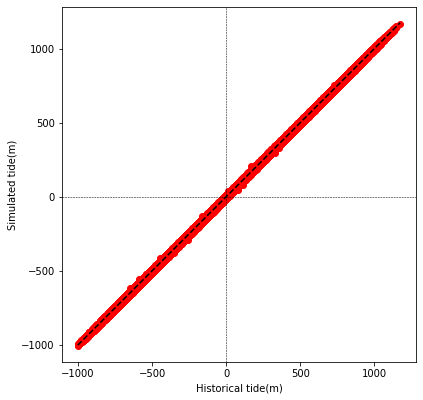

In [8]:
# --------------------------------------
# Utide library - Validation
coef = utide.solve(
    matplotlib.dates.date2num(time), tide,
    lat=lat0,
    nodal=True,
    method='ols',
    conf_int='MC'
)

tide_tt = utide.reconstruct(matplotlib.dates.date2num(time), coef).h

# Plot validation 
Plot_ValidateTTIDE(time, tide, tide_tt);
Plot_Validate_scatter(tide, tide_tt, 'Historical tide(m)', 'Simulated tide(m)');



## Astronomical Tide - Prediction

In [9]:
# --------------------------------------
# Utide library - Prediction

def utide_pred_one_year(y):
    'Predicts one year using utide library (to avoid kernel error)'
    
    # make hourly array (one year)
    d_pred = np.arange(
        np.datetime64('{0}-01-01'.format(y)), np.datetime64('{0}-01-01'.format(y+1)),
        dtype='datetime64[h]'
    )

    # reconstruct tide using utide
    return utide.reconstruct(matplotlib.dates.date2num(d_pred), coef).h


# use utide for every year
atide_pred = np.concatenate([utide_pred_one_year(y) for y in range(y1_sim, y2_sim)])

date_pred = np.arange(
    np.datetime64('{0}-01-01'.format(y1_sim)), np.datetime64('{0}-01-01'.format(y2_sim)), 
    dtype='datetime64[h]'
).astype(datetime)

# use xarray
ASTRO_sim = xr.Dataset({'astro' :(('time',), atide_pred)}, {'time' : date_pred})
print(ASTRO_sim)
    
# store astronomical tide simulation
db.Save_TIDE_sim_astro(ASTRO_sim)


prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ..

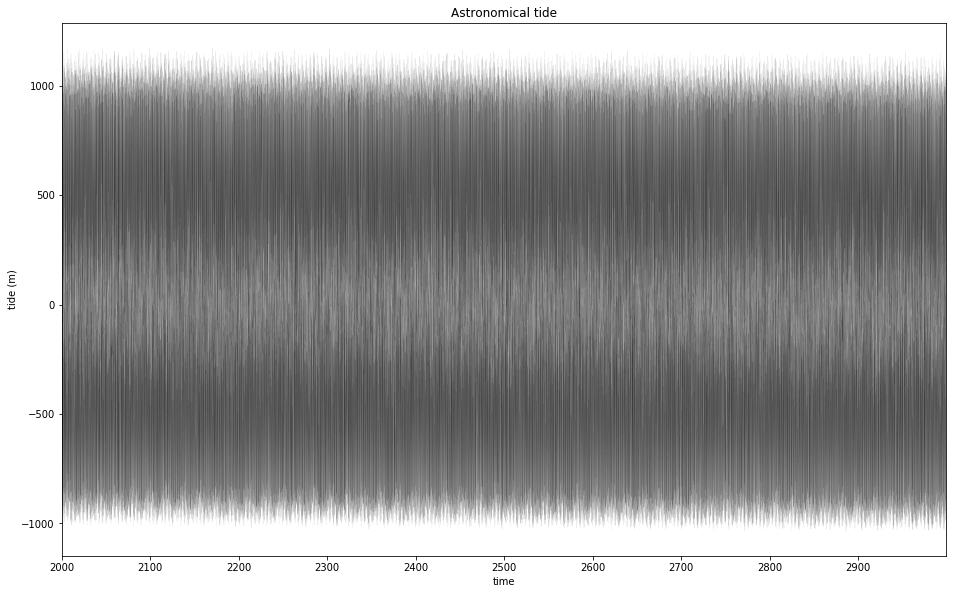

In [10]:
# Plot astronomical tide prediction
Plot_AstronomicalTide(ASTRO_sim.time.values[:], ASTRO_sim.astro.values[:]);
